### DM-09 Quiz  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

#### Parameters  

In [2]:
csv_in = 'fa-1.csv'

%config InlineBackend.figure_formats = {'png', 'retina'}  # for high-reso graph

#### Read CSV data  

In [3]:
df_all = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df_all.shape)
print(df_all.info())
display(df_all.head())

(10, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   com        10 non-null     object
 1   sporty     10 non-null     int64 
 2   reliable   10 non-null     int64 
 3   refined    10 non-null     int64 
 4   creative   10 non-null     int64 
 5   stylish    10 non-null     int64 
 6   high_tech  10 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 688.0+ bytes
None


,com,sporty,reliable,refined,creative,stylish,high_tech
0,A,7,3,7,4,7,3
1,B,6,2,5,2,6,1
2,C,6,8,6,8,9,10
3,D,1,10,1,10,3,10
4,E,2,8,3,8,2,6


In [4]:
df = df_all.loc[:, 'sporty':]
display(df.head())

,sporty,reliable,refined,creative,stylish,high_tech
0,7,3,7,4,7,3
1,6,2,5,2,6,1
2,6,8,6,8,9,10
3,1,10,1,10,3,10
4,2,8,3,8,2,6


#### Factor analysis  

In [5]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='ml')
fa.fit(df.values)

FactorAnalyzer(method='ml', n_factors=2, rotation='varimax', rotation_kwargs={})

#### Correlation matrix (相関行列)   

In [6]:
df_corr = df.corr(method='pearson')
display(df_corr)

,sporty,reliable,refined,creative,stylish,high_tech
sporty,1.000000,0.129308,0.935608,-0.239610,0.901274,0.224522
reliable,0.129308,1.000000,0.354709,0.818015,0.164706,0.956674
refined,0.935608,0.354709,1.000000,0.054443,0.836958,0.419399
creative,-0.239610,0.818015,0.054443,1.000000,-0.068843,0.811321
stylish,0.901274,0.164706,0.836958,-0.068843,1.000000,0.320555
high_tech,0.224522,0.956674,0.419399,0.811321,0.320555,1.000000


#### Eigenvalues (固有値)  

In [7]:
eigen_org, eigen_cf = fa.get_eigenvalues()
ser_eigen_org = pd.Series(eigen_org)
ser_eigen_cf = pd.Series(eigen_cf)
print(ser_eigen_org)
print(ser_eigen_cf)

0    3.276320
1    2.365791
2    0.196589
3    0.137396
4    0.021408
5    0.002497
dtype: float64
0    3.205818
1    2.283495
2    0.072584
3    0.052140
4   -0.037200
5   -0.049466
dtype: float64


#### Scree plot (スクリープロット)  

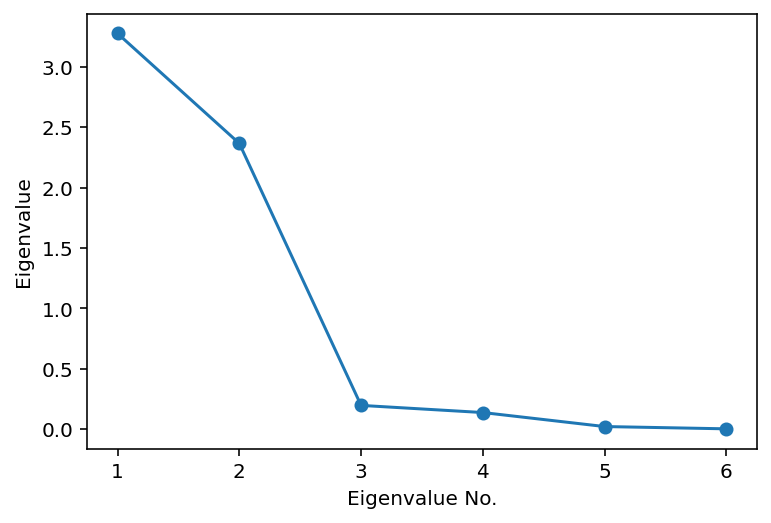

In [8]:
x = np.array(range(len(ser_eigen_org)))+1
plt.plot(x, ser_eigen_org, marker='o')
plt.xlabel('Eigenvalue No.')
plt.ylabel('Eigenvalue')
plt.show()

**Number of factors: two seems to be appropriate because the third eigenvalue is less than 1 and also the graph becomes gently-sloping at the third eigenvalue.**  
**3つめの固有値は1を下回っていて、かつそこからグラフがなだらかになっているので、因子数は2が良さそう**  

**Ans. 2**  

#### Loadings (因子負荷量)  

In [9]:
loadings = fa.loadings_
df_loadings = pd.DataFrame(loadings, index=df.columns,
                           columns=['Factor1','Factor2'])
display(df_loadings)

,Factor1,Factor2
sporty,0.996639,-0.044411
reliable,0.171870,0.954833
refined,0.945318,0.190159
creative,-0.194522,0.907368
stylish,0.904954,0.065690
high_tech,0.267175,0.951464


#### Scores (因子得点)  

In [10]:
scores = fa.transform(df)
df_scores = pd.DataFrame(scores, columns=['Factor1','Factor2'])
print(df_scores.shape)
display(df_scores.head())

(10, 2)


,Factor1,Factor2
0,0.880143,-0.945743
1,0.487657,-1.342096
2,0.594977,0.737740
3,-1.228286,1.328858
4,-0.892543,0.423557


#### Uniquenesses (独自因子の割合)  

In [11]:
uniqueness = fa.get_uniquenesses()
ser_uniqueness = pd.Series(uniqueness, index=df.columns)
print(ser_uniqueness)

sporty       0.004739
reliable     0.058754
refined      0.070213
creative     0.138845
stylish      0.176743
high_tech    0.023334
dtype: float64


**Not so high uniqueness for all data,  
so all data are somehow affected by the common factors**

**Ans. "stylish" has the largest uniquenesses (= the largest ratio that can not be explained by the top 2 common factors**

#### Contribution of each factor (各共通因子の寄与)  
- Variance: 因子負荷量平方和(因子寄与)  
- Proportion Var: 寄与率  
- Cumulative Var: 累積寄与率

In [12]:
fa_var = fa.get_factor_variance()
df_fa_var = pd.DataFrame(fa_var,
                         index=['var', 'prop_var', 'cum_var'],
                         columns=['Factor1', 'Factor2'])
display(df_fa_var)

,Factor1,Factor2
var,2.844618,2.682754
prop_var,0.474103,0.447126
cum_var,0.474103,0.921229


**Ans. 92.1% of total variance can be explained by Factor1 and Factor2**  

In [13]:
# slightly modified from biplot() in pca_and_biplot.ipynb of DM-06
def biplot_fa(score_2d, loadings, load_labels=None):
    plt.figure(figsize=(10,10))
    r1 = 1.5
    r2 = 1.01
    if load_labels is None:
        load_labels = range(len(loadings))
    for i, coef in enumerate(loadings):
        plt.arrow(0, 0, coef[0]*r1, coef[1]*r1, color='r')    
        plt.text(coef[0]*r1*r2, coef[1]*r1*r2, load_labels[i],
                 color='b', fontsize=20)
    for i in range(len(score_2d)):
        m = '${}$'.format(i)
        plt.scatter(score_2d[i,0], score_2d[i,1], marker=m, s=500, c='k')
    plt.xlabel('F_1')
    plt.ylabel('F_2')
    plt.grid()
    return None

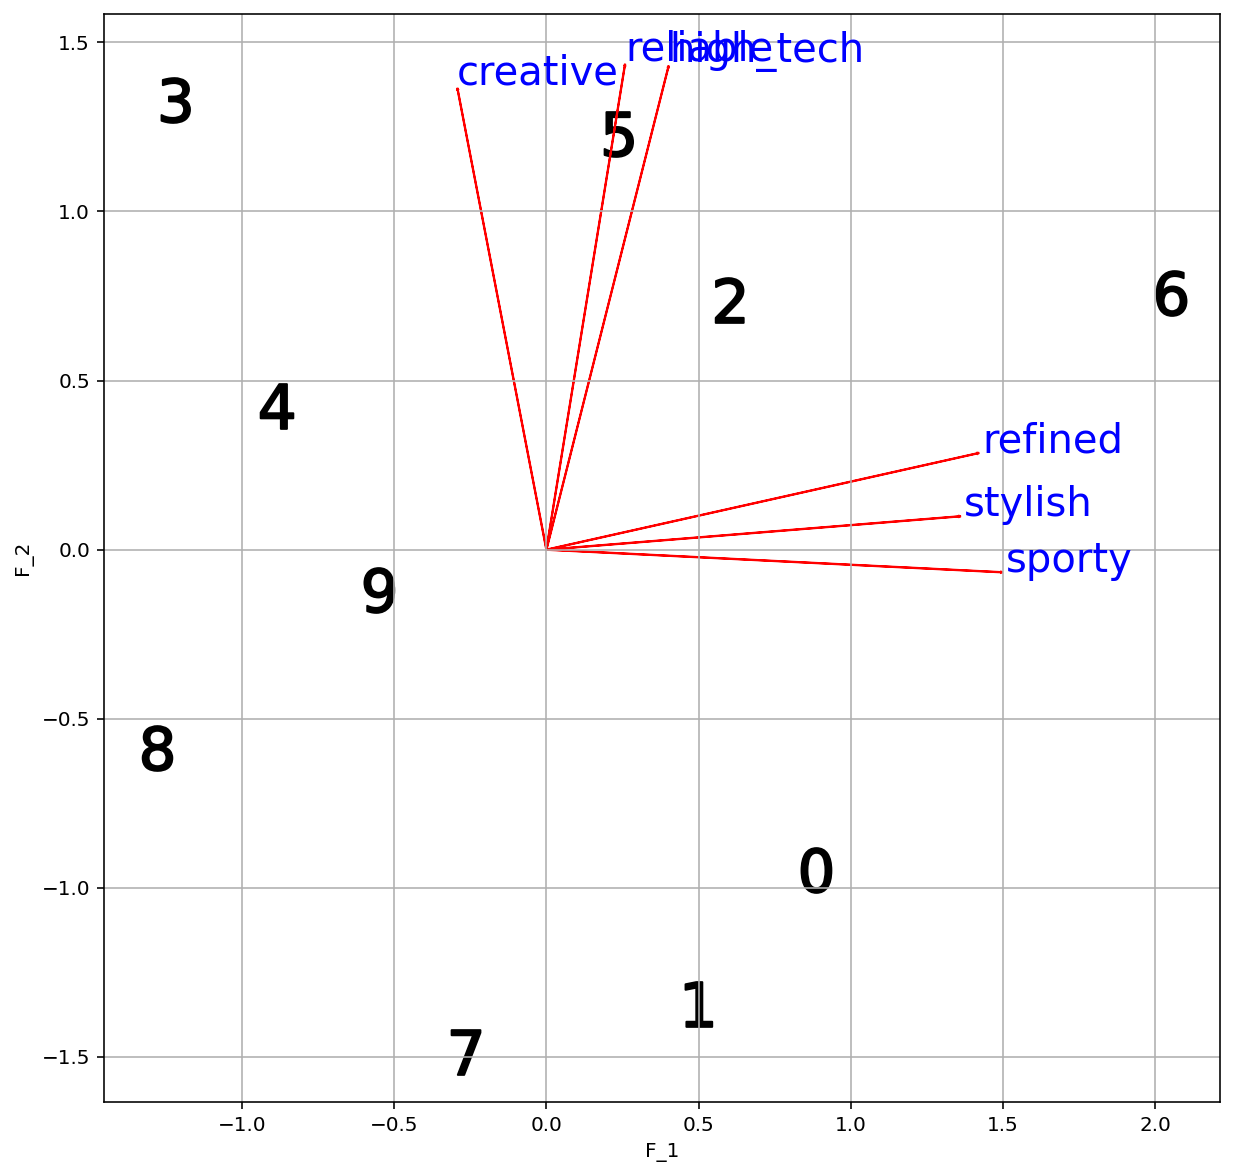

In [14]:
biplot_fa(scores, loadings, load_labels=df.columns)

**Ans. F_2 corresponds to "creative", "reliable", and "high_tech"**

**F_1: refined or not (洗練されているか), F_2: technological or not (技術が優れているか).**

**Ans. Around 0 to F_1 and positive to F_2: No.5 in biplot; corresponds to Company "F"**

In [15]:
display(df_all.head(7))

,com,sporty,reliable,refined,creative,stylish,high_tech
0,A,7,3,7,4,7,3
1,B,6,2,5,2,6,1
2,C,6,8,6,8,9,10
3,D,1,10,1,10,3,10
4,E,2,8,3,8,2,6
5,F,5,9,5,9,6,12
6,G,10,10,11,8,10,11
